In [1]:
import numpy as np
import random
import pandas as pd
from scipy.stats import wishart
from numpy.random import multivariate_normal

In [2]:
N = 943
M = 1682
# D = 60
num_epochs = 10
path = 'movielens_data/'
low = 1
high = 5
# alpha = 2


In [3]:
def Normal_Wishart( mu_0, lamb, W, nu,lamda_old,seed=None):
    
    # first draw a Wishart distribution:
    try:
        Lambda = wishart(df=nu, scale=W, seed=seed).rvs() 
    except:
        Lambda = lamda_old
#         pass
    # then draw a gaussian multivariate random variable with mean mu_0 and(lambda*Lambda)^-1 as covariance matrix.
    cov = np.linalg.pinv(lamb * Lambda) #+ 1e-6
    mu = multivariate_normal(mu_0, cov)
    return mu, Lambda, cov


In [4]:
def ranking_matrix(N, M, filename, sep="	"):
    """Function creating the NxM rating matrix from filename.
    It assumes that the file contains on every line a triple (user, movie, ranking).
    """
    R = np.zeros((N, M))
    f = open(filename, "r")
    for line in f:
        if line[0] == '%':
            # this is a comment
            continue
        (user, movie, ranking,_) = line.split(sep)
        R[np.int(user) - 1, np.int(movie) - 1] = np.int(ranking)
    return R

In [5]:
R = ranking_matrix(943,1682,"movielens-100k/u2.base")

In [6]:
t=0
for i in range(N):
    for j in range(M):
        if R[i,j] != 0:
            t = t+1

In [7]:
t

80000

In [8]:
# start_sampling
def PMF_gibbs_sampling_paper(alpha,R,R_test,U_old,V_old,low,high,start_sampling =1,mu_0=None,beta_0=None,W_0=None,nu_0=None):
    
#     R = np.zeros((N,M))
    mu_u = np.zeros((D,1))
    mu_v = np.zeros((D,1))
    lamda_u = np.eye(D)
    lamda_v = np.eye(D)
    
    train_pairs = 0
    test_pairs = 0
    for i in range(N):
        for j in range(M):
            if R[i,j] != 0:
                train_pairs = train_pairs + 1
            if R_test[i,j] != 0:
                test_pairs = test_pairs + 1
                
#     print(train_pairs)
#     print(test_pairs)
    train_pairs = 80000
                
    if mu_0 is None:
        mu_0 = np.zeros(D)
    if nu_0 is None:
        nu_0 = D
    if beta_0 is None:
        beta_0 = 2
    if W_0 is None:
        W_0 = np.eye(D)#+1e-6
        
    train_err_list = []
    test_err_list = []
    R_predict = np.zeros((N,M))
        
    lamda_old=lamda_u
    lamda_old_v=lamda_v
    for k in range(200):
        
        beta_0_star = beta_0 + N
        nu_0_star = nu_0 + N
        W_0_inv = np.linalg.pinv(W_0)
        
       
        #user hyperparameters
        U_avg = np.sum(U_old, axis=1)/N
        S_bar_u = np.matmul(U_old,U_old.T)/N
        mu_0_star_u = (beta_0*mu_0 + N*U_avg )/beta_0_star
        W_0_star_u_inv = W_0_inv + N*S_bar_u + beta_0 * N / beta_0_star * np.matmul((mu_0 - U_avg) , (mu_0 - U_avg).T)
        W_0_star_u = np.linalg.pinv(W_0_star_u_inv)
        mu_u, lamda_u , cov_u = Normal_Wishart(mu_0_star_u,beta_0_star,W_0_star_u , nu_0_star , lamda_old)
        lamda_old = lamda_u
        
        beta_0_star = beta_0 + M
        nu_0_star = nu_0 + M
        
        #movie hyperparameters
        V_avg = np.sum(V_old, axis=1)/M
        S_bar_v = np.matmul(V_old,V_old.T)/M
        mu_0_star_v = (beta_0*mu_0 + N*V_avg )/beta_0_star
        W_0_star_v_inv = W_0_inv + N*S_bar_v + beta_0 * M / beta_0_star * np.matmul((mu_0 - U_avg) , (mu_0 - U_avg).T)
        W_0_star_v = np.linalg.pinv(W_0_star_v_inv)
        mu_v, lamda_v , cov_v = Normal_Wishart(mu_0_star_v,beta_0_star,W_0_star_v , nu_0_star,lamda_old_v)
        lamda_old_v = lamda_v
        
        
        U_new = np.array([])
        
        #gibbs sampling on user parameters
        for i in range(N):  # loop over the users
            # first compute the parameters of the distribution
            lamda_u_2 = np.zeros((D, D))  # second term in the construction of lamda_U
            mu_i_star_1 = np.zeros(D)  # first piece of mu_i_star
            for j in range(M):  # loop over the movies
                if R[i,j] != 0:  # only if movie j has been ranked by user i!
                    lamda_u_2 = lamda_u_2 + np.matmul(np.array(V_old[:,j]).T ,np.array(V_old[:,j]))
            
                    mu_i_star_1 = V_old[:, j] * R[i, j] + mu_i_star_1  
            lamda_i_star_u = lamda_u + alpha * lamda_u_2
            lamda_i_star_u_inv = np.linalg.pinv(lamda_i_star_u)

            mu_i_star_part = alpha * mu_i_star_1 + np.matmul(lamda_u,mu_u)
            mu_i_star = np.matmul(lamda_i_star_u_inv, mu_i_star_part)
            
            # extracting the Ui values and appending it to the new U matrix
            U_new = np.append(U_new, multivariate_normal(mu_i_star, lamda_i_star_u_inv))

        U_new = np.reshape(U_new, (N, D))
        U_temp = U_new
        U_new = U_new.T
#         print("Cx dcs")
        
        V_new = np.array([])
        
        for j in range(M):  # loop over the users
            # first compute the parameters of the distribution
            lamda_v_2 = np.zeros((D, D))  # second term in the construction of lamda_U
            mu_i_star_1 = np.zeros(D)  # first piece of mu_i_star
            for i in range(N):  # loop over the movies
                if R[i,j] != 0:  # only if movie j has been ranked by user i!
                    lamda_v_2 = lamda_v_2 + np.dot(np.transpose(np.array(U_new[:, i], ndmin=2)),
                                                     np.array((U_new[:, i]), ndmin=2))
                    mu_i_star_1 = U_new[:, i] * R[i, j] + mu_i_star_1 
                
            lamda_i_star_v = lamda_v + alpha * lamda_v_2
            lamda_i_star_v_inv = np.linalg.pinv(lamda_i_star_v)

            mu_i_star_part = alpha * mu_i_star_1 + np.matmul(lamda_v,mu_v)
            mu_i_star = np.matmul(lamda_i_star_v_inv, mu_i_star_part)
            
            # extracting the Ui values and appending it to the new U matrix
            V_new = np.append(V_new, multivariate_normal(mu_i_star, lamda_i_star_v_inv))

        V_new = np.reshape(V_new, (M, D)).T
        
#         print(1)
#         break
        print("Epoch {} completed".format(k))
        # we will be using last 100 U,V samples to find the Rank Prediction Matrix 
        if k > start_sampling:
            
            R_step = np.dot(U_new.T, V_new)
            for i in range(N):  # reduce all the predictions to the correct ratings range.
                for j in range(M):
                    if R_step[i, j] > high:
                        R_step[i, j] = high
                    elif R_step[i, j] < low:
                        R_step[i, j] = low
                        
#             R_pred_buffer = R_pred_buffer.append(R_step)
#             R_pred = np.mean(R_pred_buffer,axis=0)
            R_predict = R_predict*(k-start_sampling-1)/(k-start_sampling) + R_step/(k-start_sampling)
#             print(R_predict.shape)
            
            train_err = 0
            test_err = 0
            
            for i in range(N):
                for j in range(M):
                    if R[i,j] != 0 :
                        train_err = train_err + (R_predict[i, j] - R[i, j]) ** 2
#                         print(train_err)
            
            train_err_list.append(np.sqrt(train_err / train_pairs))
#             print("Epoch {}".format(k))
            print("Train RMSE at iteration {} = {}".format(k,train_err/train_pairs))
            
            for i in range(N):
                for j in range(M):
                    if R_test[i,j] != 0 :
                        test_err = test_err + (R_predict[i, j] - R_test[i, j]) ** 2
            
            train_err_list.append(np.sqrt(test_err / test_pairs))
            print("Test RMSE at iteration {} = {}".format(k,test_err/test_pairs))
            
        U_old = U_new
#         print(U_old.shape)
#         break
        V_old = V_new
            
        
    return R_predict, train_err_list, test_err_list
        
        
    
    
    
    

In [9]:
alpha = 2
D=60
R = ranking_matrix(N, M, "movielens-100k/u2.base")
R_test = ranking_matrix(N, M, "movielens-100k/u2.test")
U_in = np.zeros((D, N)) #+1e-6 
V_in = np.zeros((D, M)) #+1e-6

In [10]:
R_pred, train_err, test_err = PMF_gibbs_sampling_paper(alpha,R, R_test, U_in, V_in, low,
                                                     high)


Epoch 0 completed
Epoch 1 completed
Epoch 2 completed
Train RMSE at iteration 2 = 7.6473375
Test RMSE at iteration 2 = 7.74725
Epoch 3 completed
Train RMSE at iteration 3 = 4.313387830358
Test RMSE at iteration 3 = 4.7497351808466926
Epoch 4 completed
Train RMSE at iteration 4 = 3.7692072132243126
Test RMSE at iteration 4 = 4.212293804482213


/home/namanb/.local/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: covariance is not symmetric positive-semidefinite.


Epoch 5 completed
Train RMSE at iteration 5 = 2.53842534488871
Test RMSE at iteration 5 = 2.8233213506275088
Epoch 6 completed
Train RMSE at iteration 6 = 1.9751405969057916
Test RMSE at iteration 6 = 2.187246353352002
Epoch 7 completed
Train RMSE at iteration 7 = 1.6669358869538151
Test RMSE at iteration 7 = 1.841475519199126
Epoch 8 completed
Train RMSE at iteration 8 = 1.4837767611400068
Test RMSE at iteration 8 = 1.635007503967946
Epoch 9 completed
Train RMSE at iteration 9 = 1.3655653882933043
Test RMSE at iteration 9 = 1.4991007853426805
Epoch 10 completed
Train RMSE at iteration 10 = 1.2839356410548197
Test RMSE at iteration 10 = 1.4062959465476392
Epoch 11 completed
Train RMSE at iteration 11 = 1.2256241142244804
Test RMSE at iteration 11 = 1.3399421096230044
Epoch 12 completed
Train RMSE at iteration 12 = 1.1836559190174123
Test RMSE at iteration 12 = 1.2908542094387128
Epoch 13 completed
Train RMSE at iteration 13 = 1.150708647792281
Test RMSE at iteration 13 = 1.253703718972

/home/namanb/.local/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: covariance is not symmetric positive-semidefinite.


Epoch 23 completed
Train RMSE at iteration 23 = 1.0558531147542325
Test RMSE at iteration 23 = 1.148258250279844
Epoch 24 completed
Train RMSE at iteration 24 = 1.056917818878346
Test RMSE at iteration 24 = 1.1491551368355166
Epoch 25 completed
Train RMSE at iteration 25 = 1.0549675579072029
Test RMSE at iteration 25 = 1.148206778702621
Epoch 26 completed
Train RMSE at iteration 26 = 1.053137177634373
Test RMSE at iteration 26 = 1.146226878627469
Epoch 27 completed
Train RMSE at iteration 27 = 1.0516956834321727
Test RMSE at iteration 27 = 1.1438739870150207
Epoch 28 completed
Train RMSE at iteration 28 = 1.048437401106625
Test RMSE at iteration 28 = 1.1415187949607557
Epoch 29 completed
Train RMSE at iteration 29 = 1.0458172114711526
Test RMSE at iteration 29 = 1.1388363809064128
Epoch 30 completed
Train RMSE at iteration 30 = 1.0441757495068065
Test RMSE at iteration 30 = 1.1365977977887316
Epoch 31 completed
Train RMSE at iteration 31 = 1.04222846263694
Test RMSE at iteration 31 = 1

Test RMSE at iteration 95 = 1.047582307430488
Epoch 96 completed
Train RMSE at iteration 96 = 0.9245975298604125
Test RMSE at iteration 96 = 1.047226270732697
Epoch 97 completed
Train RMSE at iteration 97 = 0.9233352987666779
Test RMSE at iteration 97 = 1.0467913787715655
Epoch 98 completed
Train RMSE at iteration 98 = 0.9223392872620905
Test RMSE at iteration 98 = 1.0462970110385552
Epoch 99 completed
Train RMSE at iteration 99 = 0.9212658369709332
Test RMSE at iteration 99 = 1.0460035710973246
Epoch 100 completed
Train RMSE at iteration 100 = 0.9201110123982873
Test RMSE at iteration 100 = 1.0453987437370016
Epoch 101 completed
Train RMSE at iteration 101 = 0.919313896554856
Test RMSE at iteration 101 = 1.045025327141129
Epoch 102 completed
Train RMSE at iteration 102 = 0.918117416406491
Test RMSE at iteration 102 = 1.0448818148893115
Epoch 103 completed
Train RMSE at iteration 103 = 0.9172175821361765
Test RMSE at iteration 103 = 1.0445679128823075
Epoch 104 completed
Train RMSE at 

Epoch 166 completed
Train RMSE at iteration 166 = 0.8692809117340001
Test RMSE at iteration 166 = 1.029137826569813
Epoch 167 completed
Train RMSE at iteration 167 = 0.8686708150012391
Test RMSE at iteration 167 = 1.0289923111577477
Epoch 168 completed
Train RMSE at iteration 168 = 0.8680589637502668
Test RMSE at iteration 168 = 1.0288662068665255
Epoch 169 completed
Train RMSE at iteration 169 = 0.8675811973876655
Test RMSE at iteration 169 = 1.0287245837870296
Epoch 170 completed
Train RMSE at iteration 170 = 0.8670335647586574
Test RMSE at iteration 170 = 1.0285451259262992
Epoch 171 completed
Train RMSE at iteration 171 = 0.8665998676849136
Test RMSE at iteration 171 = 1.0284486647232918
Epoch 172 completed
Train RMSE at iteration 172 = 0.866040037547054
Test RMSE at iteration 172 = 1.0281974788578532
Epoch 173 completed
Train RMSE at iteration 173 = 0.8656415516510205
Test RMSE at iteration 173 = 1.028173197961625
Epoch 174 completed
Train RMSE at iteration 174 = 0.865111548471496

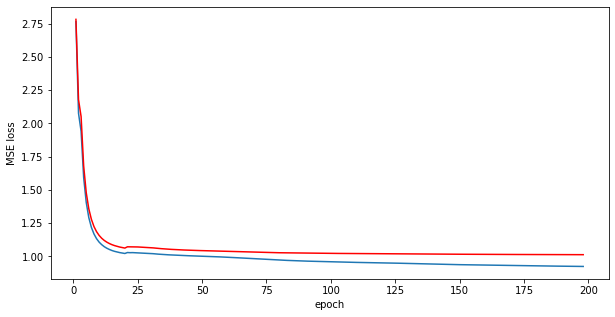

In [31]:
train = []
test = []
for i in range(len(train_err)):
    if i%2 == 0:
        train.append(train_err[i])
    else:
        test.append(train_err[i])
x = []
for i in range(1,199):
    x.append(i)
plt.figure(figsize=(10,5))
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.plot(x,train)
plt.plot(x,test,'r')
plt.show()

In [29]:
len(test)

198

In [11]:
alpha = 2
D=100
R = ranking_matrix(N, M, "movielens-100k/u2.base")
R_test = ranking_matrix(N, M, "movielens-100k/u2.test")
U_in = np.zeros((D, N)) #+1e-6 
V_in = np.zeros((D, M)) #+1e-6

In [12]:
R_pred2, train_err2, test_err2 = PMF_gibbs_sampling_paper(alpha,R, R_test, U_in, V_in, low,
                                                     high)

Epoch 0 completed
Epoch 1 completed
Epoch 2 completed
Train RMSE at iteration 2 = 7.535520014159935
Test RMSE at iteration 2 = 7.688100574184387
Epoch 3 completed
Train RMSE at iteration 3 = 4.320740055555748
Test RMSE at iteration 3 = 4.765336181898591


/home/namanb/.local/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: covariance is not symmetric positive-semidefinite.


Epoch 4 completed
Train RMSE at iteration 4 = 3.80324500983322
Test RMSE at iteration 4 = 4.288729775442378
Epoch 5 completed
Train RMSE at iteration 5 = 2.5706026262219033
Test RMSE at iteration 5 = 2.8830879681329526
Epoch 6 completed
Train RMSE at iteration 6 = 1.997894139842166
Test RMSE at iteration 6 = 2.229927294403356
Epoch 7 completed
Train RMSE at iteration 7 = 1.6882768096278755
Test RMSE at iteration 7 = 1.8741478489890477
Epoch 8 completed
Train RMSE at iteration 8 = 1.499923584060529
Test RMSE at iteration 8 = 1.659457477882567
Epoch 9 completed
Train RMSE at iteration 9 = 1.3786956696234294
Test RMSE at iteration 9 = 1.5192456633509814
Epoch 10 completed
Train RMSE at iteration 10 = 1.2954128258752027
Test RMSE at iteration 10 = 1.4240570703149165
Epoch 11 completed
Train RMSE at iteration 11 = 1.2366063915969183
Test RMSE at iteration 11 = 1.355340707580955
Epoch 12 completed
Train RMSE at iteration 12 = 1.1929437199385344
Test RMSE at iteration 12 = 1.3044506289535107


/home/namanb/.local/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: covariance is not symmetric positive-semidefinite.


Epoch 39 completed
Train RMSE at iteration 39 = 0.9994079606820556
Test RMSE at iteration 39 = 1.0785977287890012
Epoch 40 completed
Train RMSE at iteration 40 = 0.9959852220189712
Test RMSE at iteration 40 = 1.076650627737652
Epoch 41 completed
Train RMSE at iteration 41 = 0.9919292007262478
Test RMSE at iteration 41 = 1.0741347969713224
Epoch 42 completed
Train RMSE at iteration 42 = 0.9888089006590081
Test RMSE at iteration 42 = 1.072102167252142
Epoch 43 completed
Train RMSE at iteration 43 = 0.9858341140688657
Test RMSE at iteration 43 = 1.070225448429924
Epoch 44 completed
Train RMSE at iteration 44 = 0.9825591216315032
Test RMSE at iteration 44 = 1.0686550307892289
Epoch 45 completed
Train RMSE at iteration 45 = 0.9798076255777612
Test RMSE at iteration 45 = 1.0669869604120954
Epoch 46 completed
Train RMSE at iteration 46 = 0.976483935056443
Test RMSE at iteration 46 = 1.06551736415631
Epoch 47 completed
Train RMSE at iteration 47 = 0.9735120769146317
Test RMSE at iteration 47 =

Epoch 111 completed
Train RMSE at iteration 111 = 0.8663455394589471
Test RMSE at iteration 111 = 1.0254606638352441
Epoch 112 completed
Train RMSE at iteration 112 = 0.8651657458451733
Test RMSE at iteration 112 = 1.025243487561359
Epoch 113 completed
Train RMSE at iteration 113 = 0.8639528841601084
Test RMSE at iteration 113 = 1.0251377306352143
Epoch 114 completed
Train RMSE at iteration 114 = 0.8629283814982806
Test RMSE at iteration 114 = 1.0250610886782021
Epoch 115 completed
Train RMSE at iteration 115 = 0.8617483438014669
Test RMSE at iteration 115 = 1.0249187574256509
Epoch 116 completed
Train RMSE at iteration 116 = 0.860759321209494
Test RMSE at iteration 116 = 1.0248187893606207
Epoch 117 completed
Train RMSE at iteration 117 = 0.8596036960789163
Test RMSE at iteration 117 = 1.0245940457031615
Epoch 118 completed
Train RMSE at iteration 118 = 0.8586203715328956
Test RMSE at iteration 118 = 1.024496687565234
Epoch 119 completed
Train RMSE at iteration 119 = 0.857717511087564

Test RMSE at iteration 181 = 1.0183143421058591
Epoch 182 completed
Train RMSE at iteration 182 = 0.8202441759308778
Test RMSE at iteration 182 = 1.018274655009663
Epoch 183 completed
Train RMSE at iteration 183 = 0.8198740095392363
Test RMSE at iteration 183 = 1.0183290343030773
Epoch 184 completed
Train RMSE at iteration 184 = 0.819534650878945
Test RMSE at iteration 184 = 1.0182895514969994
Epoch 185 completed
Train RMSE at iteration 185 = 0.8192236261893328
Test RMSE at iteration 185 = 1.0183087271825624
Epoch 186 completed
Train RMSE at iteration 186 = 0.8188581895553811
Test RMSE at iteration 186 = 1.0182692062137721
Epoch 187 completed
Train RMSE at iteration 187 = 0.818546557106327
Test RMSE at iteration 187 = 1.0181829548716332
Epoch 188 completed
Train RMSE at iteration 188 = 0.8181598810388641
Test RMSE at iteration 188 = 1.018171259593417
Epoch 189 completed
Train RMSE at iteration 189 = 0.8178450489352018
Test RMSE at iteration 189 = 1.0180456404087497
Epoch 190 completed


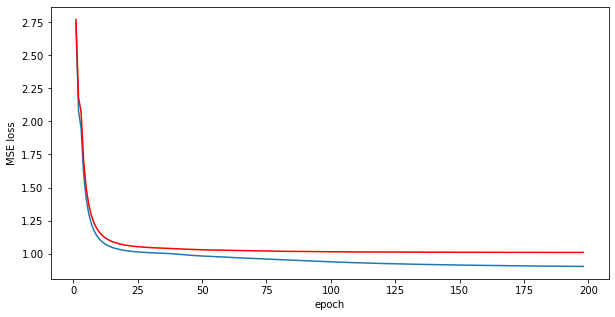

In [33]:
train2 = []
test2 = []
for i in range(len(train_err2)):
    if i%2 == 0:
        train2.append(train_err2[i])
    else:
        test2.append(train_err2[i])
x = []
for i in range(1,199):
    x.append(i)
plt.figure(figsize=(10,5))
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.plot(x,train2)
plt.plot(x,test2,'r')
plt.show()